# Plots the Sea Surface Temperature (SST) anomaly map for the preceding month, calculated from the daily mean

### Using the Climate Data Operators to calculate the daily anomalies 

0) concatenate the whole period 

`ncrcat $(/bin/ls -v  sst.day.mean.????.v2.nc) sst.day.mean.1981.2019.v2.nc`

1) concatenate the 1981 - 2010 period:  

`ncrcat $(cat lfiles) sst.day.mean.1981.2010.v2.nc`

2) calculate the daily climatology:  

`cdo ydaymean sst.day.mean.1981.2010.v2.nc sst.day.mean.1981.2010.climatology.v2.nc`

3) calculate the anomalies:  

`cdo ydaysub sst.day.mean.1981.2019.v2.nc sst.day.mean.1981.2010.climatology.v2.nc sst.day.anoms.1981.2017.v2.nc`


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import os
import pathlib
from subprocess import call
import numpy as np
from numpy import ma
from datetime import datetime
from matplotlib import cm

import pandas as pd
import xarray as xr
import salem

In [3]:
from datetime import datetime
from dateutil.parser import parse as dparse
import calendar

In [4]:
import fiona
import geopandas 

In [5]:
import cmocean

In [6]:
from matplotlib import style

In [7]:
import seaborn as sns
sns.set_context('talk')

In [8]:
def format_vals(x):
    return "{:+4.2f}\n".format(x)

In [9]:
def make_vals(df): 
    vals = df.iloc[-1,:].to_frame()
    vals.columns = ['vals']
    vals = vals.sort_values(by='vals', ascending=False)
    valsf = list(map(format_vals, vals.values.flatten()))
    valsf = "".join(valsf)
    return valsf

### set the end date here 

In [10]:
end_date = datetime.utcnow()

### working directory 

In [11]:
CWD = pathlib.Path.cwd()

In [12]:
HOME = pathlib.Path.home()

### set up directories paths

In [13]:
# data 
dpath = HOME / 'data' / 'SST' / 'NOAA_hires_1981_present' / 'NZ'

In [14]:
fpath = CWD.parent / 'figures'

In [15]:
if not fpath.exists(): 
    fpath.mkdir()

In [16]:
opath = CWD.parent / 'outputs'

In [17]:
if not opath.exists(): 
    opath.mkdir()

In [18]:
vpath = pathlib.Path.home() / 'drives' / 'well_scratch' / 'ncc' / 'SSTs'

### set the domain boundaries 

In [19]:
ll_lon = 160
ur_lon = 180

ll_lat = -50
ur_lat = -30

In [20]:
dpath.parent

PosixPath('/home/nicolasf/data/SST/NOAA_hires_1981_present')

In [21]:
dpath_download = dpath.parent

today = datetime.utcnow() 

today = end_date

dtdown = today

fname = "sst.day.mean.{}.v2.nc".format(dtdown.strftime("%Y"))

In [22]:
fname

'sst.day.mean.2019.v2.nc'

### download from [ftp://ftp.cdc.noaa.gov/Datasets/noaa.oisst.v2.highres/](ftp://ftp.cdc.noaa.gov/Datasets/noaa.oisst.v2.highres/)

In [23]:
download = True

In [24]:
if download: 
    print("trying to download {}".format(fname))
    cmd = "curl --silent ftp://ftp.cdc.noaa.gov/Datasets/noaa.oisst.v2.highres/{} -o {}".format(fname, os.path.join(str(dpath_download),fname))
    rcode = call(cmd,shell=True)
    if rcode != 0: 
        print("something went wrong with the download of {}".format(fname))

trying to download sst.day.mean.2019.v2.nc


### extraction

In [25]:
ncks = HOME / 'anaconda3' / 'envs' / 'NCO' / 'bin' / 'ncks'

In [26]:
cmd = '{0} -FOa -d lat,{1}.,{2}. -d lon,{3}.,{4}. {5}/{6} {5}/NZ/{6}'.format(ncks, ll_lat, ur_lat, ll_lon, ur_lon, str(dpath_download), fname)
rcode = call(cmd,shell=True)
if rcode != 0: 
    print("something went wrong the domain extraction of {}".format(fname))   

In [27]:
cmd

'/home/nicolasf/anaconda3/envs/NCO/bin/ncks -FOa -d lat,-50.,-30. -d lon,160.,180. /home/nicolasf/data/SST/NOAA_hires_1981_present/sst.day.mean.2019.v2.nc /home/nicolasf/data/SST/NOAA_hires_1981_present/NZ/sst.day.mean.2019.v2.nc'

### now runs the climate data operators

In [28]:
os.chdir(dpath)

In [29]:
dpath

PosixPath('/home/nicolasf/data/SST/NOAA_hires_1981_present/NZ')

In [30]:
lfiles = ['sst.day.mean.1981.2019.v2.nc', 'sst.day.anoms.1981.2019.v2.nc']

In [31]:
for f in lfiles: 
    os.remove(os.path.join(dpath, f))

In [32]:
ncrcat = HOME / 'anaconda3' / 'envs' / 'NCO' / 'bin' / 'ncrcat'

In [33]:
call("{} $(/bin/ls -v  sst.day.mean.????.v2.nc) sst.day.mean.1981.2019.v2.nc".format(ncrcat), shell=True)

0

In [34]:
cdo = HOME / 'anaconda3' / 'envs' / 'CDO' / 'bin' / 'cdo'

In [35]:
call("{} ydaysub sst.day.mean.1981.2019.v2.nc sst.day.mean.1981.2010.climatology.v2.nc sst.day.anoms.1981.2019.v2.nc".format(cdo), shell=True)

0

### opens the dataset of anomalies

In [36]:
sst_ts = salem.open_xr_dataset(os.path.join(dpath, 'sst.day.anoms.1981.2019.v2.nc'))

In [37]:
print(sst_ts.time[-1].data)

2019-04-27T00:00:00.000000000


### make plots 

In [38]:
def plot_map_salem(compos, ax, vmin, vmax, cmap): 
    smap = compos.salem.get_map(countries=False)
    smap.set_shapefile(countries=True, color='0.4', linewidth=0.5)
    smap.set_cmap(plt.cm.RdBu_r)
    smap.set_lonlat_contours(linewidths=0.1)
    xx, yy = smap.grid.transform(compos.lon.data, compos.lat.data,
                             crs=compos.salem.grid.proj)
    im = ax.pcolormesh(xx, yy, ma.masked_invalid(compos), vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im, shrink=0.8, ax=ax)
    smap.plot(ax=ax) 

In [39]:
def plot_map_cartopy(dset, var='sst', ndays=7, cmap=cmocean.cm.balance, vmin=-2, vmax=2, step=0.1, ax=None, title=None): 
    
    import matplotlib.ticker as mticker
    import cartopy
    import cartopy.crs as ccrs
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    from cartopy import feature as cfeature 
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    
    central_longitude = 180.
    
    proj = ccrs.PlateCarree(central_longitude=central_longitude)
    
    mat = dset.isel(time=slice(-ndays, None)).mean('time')
    
    lon, lat = mat.lon.data, mat.lat.data
    
    im1 = ax.contourf(lon, lat, mat['sst'], levels=np.arange(vmin, vmax + step, step), extend='both', \
               cmap=plt.get_cmap('RdBu_r'))

    im = ax.contour(lon, lat, mat['sst'], levels=np.arange(vmin, vmax + step, step*2), extend='both', \
               cmap=cmap)

    xticks = np.arange(ll_lon, ur_lon +5., 5.)

    yticks = np.arange(ll_lat, ur_lat + 5., 5.)

    gl = ax.gridlines(draw_labels=False, lw=0.5, linestyle=':', xlocs=xticks, ylocs=yticks, crs=ccrs.PlateCarree())

    ax.set_xticks(xticks, crs=ccrs.PlateCarree())

    ax.set_yticks(yticks, crs=ccrs.PlateCarree())

    lon_formatter = LongitudeFormatter(zero_direction_label=True, dateline_direction_label=True)

    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)

    ax.yaxis.set_major_formatter(lat_formatter)

    ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor=None, facecolor='white')

    ax.coastlines(resolution='10m', zorder=10)

    cb = plt.colorbar(im1, shrink=0.7)
    cb.set_label('℃ (anomalies)')

    ax.set_extent([ll_lon, ur_lon, ll_lat, ur_lat])
    
    if title is None: 
        ax.set_title('NOAA OISST anomalies [1981-2010 clim.]\n{} days average to {:%d %b %Y}'.format(ndays, pd.to_datetime(str(dset.time[-1].data))))
    else: 
        ax.set_title(title)

In [40]:
cmap = cmocean.cm.balance

In [41]:
os.chdir(CWD)

In [42]:
from cartopy import crs as ccrs

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


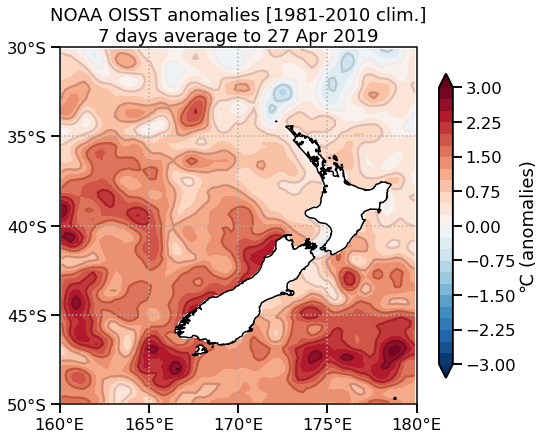

In [43]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(8,8))
plot_map_cartopy(sst_ts, vmin = -3, vmax=3, step=0.25, ax = ax)
f.savefig(fpath / 'latest_7_days_1981_2010_climo.png', dpi=300)

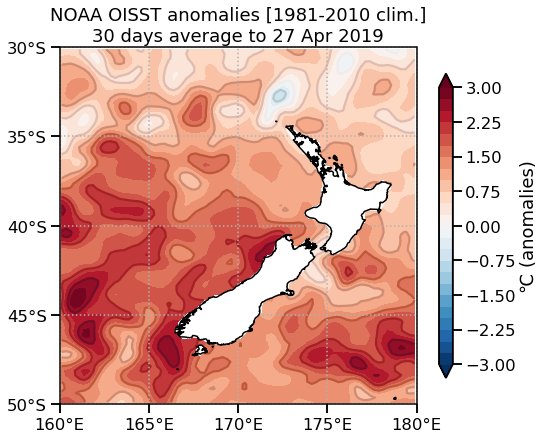

In [44]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(8,8))
plot_map_cartopy(sst_ts, ndays=30, ax = ax, vmin = -3, vmax=3, step=0.25)
f.savefig(fpath / 'latest_30_days_1981_2010_climo.png', dpi=300)

In [45]:
last_day = sst_ts.time[-1].data.astype('M8[D]').astype('O')

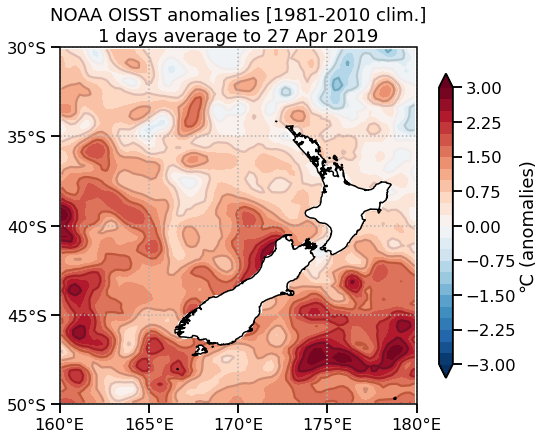

In [46]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(8,8))
plot_map_cartopy(sst_ts, ndays=1, ax = ax, vmin = -3, vmax=3, step=0.25)
f.savefig(fpath / 'latest_1_days_1981_2010_climo.png', dpi=300)

### removes the 29th of Februaries .. 

In [47]:
dates = sst_ts.time

In [48]:
dates = pd.to_datetime(dates.to_index())

In [49]:
dates = pd.DataFrame(dates, index=dates)
dates.columns = ['dates']

In [50]:
dates['dates'] = dates.dates.astype(str)

In [51]:
dates = dates[~dates.dates.str.endswith('02-29')]

In [52]:
dates.index

DatetimeIndex(['1981-09-01', '1981-09-02', '1981-09-03', '1981-09-04',
               '1981-09-05', '1981-09-06', '1981-09-07', '1981-09-08',
               '1981-09-09', '1981-09-10',
               ...
               '2019-04-18', '2019-04-19', '2019-04-20', '2019-04-21',
               '2019-04-22', '2019-04-23', '2019-04-24', '2019-04-25',
               '2019-04-26', '2019-04-27'],
              dtype='datetime64[ns]', name='time', length=13744, freq=None)

In [53]:
sst_ts = sst_ts.sel(time=dates.index)

In [54]:
sst_ts

<xarray.Dataset>
Dimensions:  (lat: 80, lon: 80, time: 13744)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2019-04-27
  * lon      (lon) float32 160.125 160.375 160.625 ... 179.375 179.625 179.875
  * lat      (lat) float32 -49.875 -49.625 -49.375 ... -30.625 -30.375 -30.125
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    history:        Mon Apr 29 10:25:15 2019: cdo ydaysub sst.day.mean.1981.2...
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    institution:    NOAA/NCDC
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    references:     http://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    Refere

### for all regions, creates the ROI and calculates the regional average

In [55]:
# NNI = salem.read_shapefile('./NNI_buffered_2.shp')
# WNI = salem.read_shapefile('./WNI_buffered_2.shp')
# ENI = salem.read_shapefile('./ENI_buffered_2.shp')
# NSI = salem.read_shapefile('./NSI_buffered_2.shp')
# WSI = salem.read_shapefile('./WSI_buffered_2.shp')
# ESI = salem.read_shapefile('./ESI_buffered_2.shp')

In [56]:
NNI = salem.read_shapefile(CWD.parent / 'data' / 'shapefiles' / 'NNI_buffered_50km.shp')
WNI = salem.read_shapefile(CWD.parent / 'data' / 'shapefiles' / 'WNI_buffered_50km.shp')
ENI = salem.read_shapefile(CWD.parent / 'data' / 'shapefiles' / 'ENI_buffered_50km.shp')
NSI = salem.read_shapefile(CWD.parent / 'data' / 'shapefiles' / 'NSI_buffered_50km.shp')
WNI = salem.read_shapefile(CWD.parent / 'data' / 'shapefiles' / 'WNI_buffered_50km.shp')
ESI = salem.read_shapefile(CWD.parent / 'data' / 'shapefiles' / 'ESI_buffered_50km.shp')

In [57]:
ds_subset_roi_NNI = sst_ts.salem.roi(shape=NNI)
ds_subset_roi_WNI = sst_ts.salem.roi(shape=WNI)
ds_subset_roi_ENI = sst_ts.salem.roi(shape=ENI)
ds_subset_roi_NSI = sst_ts.salem.roi(shape=NSI)
ds_subset_roi_WSI = sst_ts.salem.roi(shape=WSI)
ds_subset_roi_ESI = sst_ts.salem.roi(shape=ESI)

NameError: name 'WSI' is not defined

In [ ]:
reg_ds_subset_roi_NNI = ds_subset_roi_NNI.mean('lon').mean('lat')
reg_ds_subset_roi_WNI = ds_subset_roi_WNI.mean('lon').mean('lat')
reg_ds_subset_roi_ENI = ds_subset_roi_ENI.mean('lon').mean('lat')
reg_ds_subset_roi_NSI = ds_subset_roi_NSI.mean('lon').mean('lat')
reg_ds_subset_roi_WSI = ds_subset_roi_WSI.mean('lon').mean('lat')
reg_ds_subset_roi_ESI = ds_subset_roi_ESI.mean('lon').mean('lat')

In [ ]:
df_NNI = reg_ds_subset_roi_NNI.to_dataframe()
df_WNI = reg_ds_subset_roi_WNI.to_dataframe()
df_ENI = reg_ds_subset_roi_ENI.to_dataframe()
df_NSI = reg_ds_subset_roi_NSI.to_dataframe()
df_WSI = reg_ds_subset_roi_WSI.to_dataframe()
df_ESI = reg_ds_subset_roi_ESI.to_dataframe()

In [ ]:
df = pd.concat([df_NNI, df_WNI, df_ENI, df_NSI, df_WSI, df_ESI], axis=1)

In [ ]:
df.columns = ['NNI','WNI','ENI','NSI','WSI','ESI']

### daily SSTs

In [ ]:
df.iloc[-1,:].to_frame()

In [ ]:
valsf = make_vals(df)

In [ ]:
f, ax = plt.subplots(figsize=(12,8))

# f.subplots_adjust(right=0.8)

df.loc['2017-11':].plot(lw=2, ax=ax)

# df.loc['2017',:].rolling(window=7).mean().plot(ax=ax)

# ax.text(1.1,0.9,'NNI: 0.441509', transform=ax.transAxes )

ax.grid()

ax.axhline(0, color='k', zorder=-1)

ax.set_title('daily coastal SST anomalies (1981-2010 climatology, NOAA OISST), ending {:%Y-%m-%d}'.format(df.index[-1]), fontsize=14)

ax.set_ylabel(u"\u00b0" + "C anomalies")

# ax.text(1.01, 0.76, valsf, transform=ax.transAxes, fontsize=13)

f.savefig(fpath / 'daily_SST_index_{:%Y-%m-%d}_1981_2010_climo_50km.png'.format(df.index[-1]), dpi=200)

In [ ]:
df.to_csv(opath / 'daily_SST_index_{:%Y-%m-%d}_1981_2010_climo_50km.csv'.format(df.index[-1]))

### Monthly SSTs

In [ ]:
dfm = df.resample('1M').mean()

In [ ]:
dfm.tail()

In [ ]:
valsf = make_vals(dfm)

In [ ]:
f, ax = plt.subplots(figsize=(12,8))

dfplot = dfm.loc['2016':None]

dfplot.plot(lw=2, ax=ax)

ax.grid()

ax.axhline(0, color='k', zorder=-1)

ax.set_title('monthly coastal SST anomalies, ending {:%Y-%m}'.format(dfplot.index[-1]), fontsize=14)

ax.text(1.01, 0.76, valsf, transform=ax.transAxes, fontsize=13)

f.savefig(fpath / 'monthly_SST_index_{:%Y-%m}_1981_2010_climo_50km.png'.format(dfplot.index[-1]), dpi=200)

In [ ]:
dfm.to_csv(opath / 'monthly_SST_index_{:%Y-%m}_1981_2010_climo_50km.csv'.format(dfm.index[-1]))

### Seasonal SSTs 

In [ ]:
dfs = dfm.rolling(window=3, min_periods=3).mean()

In [ ]:
valsf = make_vals(dfs)

In [ ]:
dfs.iloc[-1,]

In [ ]:
f, ax = plt.subplots(figsize=(12,8))

dfplot = dfs.loc['2016':None]

dfplot.plot(lw=2, ax=ax)

ax.grid(ls=':')

ax.axhline(0, color='k', zorder=-1)
ax.set_title('seasonal (3 months ave.) coastal SST anomalies, ending {:%Y-%m}'.format(dfplot.index[-1]), fontsize=16)

ax.text(1.01, 0.76, valsf, transform=ax.transAxes, fontsize=13)


f.savefig(fpath / 'seasonal_SST_index_{:%Y-%m}_1981_2010_climo_50km.png'.format(dfplot.index[-1]), dpi=200)

In [ ]:
dfs.to_csv(opath / 'seasonal_SST_index_{:%Y-%m}_1981_2010_climo50km.csv'.format(dfs.index[-1]))

In [ ]:
lseas = ["".join(list('NDJFMAMJJASOND')[i:i+3]) for i in range(12)]

In [ ]:
d = dict(zip(range(1,13),lseas))

In [ ]:
dfs.loc[:,'season'] = dfs.index.month

In [ ]:
dfs = dfs.replace({'season':d})

In [ ]:
dfs.tail()

In [ ]:
for m in range(1,13): 
    
    dfss = dfs.iloc[dfs.index.month == m,:]
        
    f, ax = plt.subplots(figsize=(12,8))

    dfss.plot(lw=2, ax=ax)

    ax.grid()

    ax.axhline(0, color='k', zorder=-1)
    
    ax.set_title('{} coastal SST anomalies, ending {:%Y-%m}'.format(d[m], dfss.index[-1]), fontsize=14)

    f.savefig(fpath / '{}_seasonal_SST_index_{:%Y-%m}_1981_2010_climo.png'.format(d[m], dfss.index[-1]), dpi=200)
    
    plt.close(f)

In [ ]:
from pandas import ExcelWriter

In [ ]:
writer = ExcelWriter(opath / 'seasonal_SST_R_{:%Y-%m}_1981_2010_climo.xlsx'.format(dfss.index[-1]))

In [ ]:
for season in lseas: 
    table = dfs.query("season == '{}'".format(season)).drop('season', axis=1)
    table.to_excel(writer, season)

In [ ]:
writer.save()

In [ ]:
ds_subset_roi_NNI = ds_subset_roi_NNI.sel(lon=slice(163,None))
ds_subset_roi_WNI = ds_subset_roi_WNI.sel(lon=slice(163,None))
ds_subset_roi_ENI = ds_subset_roi_ENI.sel(lon=slice(163,None))
ds_subset_roi_NSI = ds_subset_roi_NSI.sel(lon=slice(163,None))
ds_subset_roi_WSI = ds_subset_roi_WSI.sel(lon=slice(163,None))
ds_subset_roi_ESI = ds_subset_roi_ESI.sel(lon=slice(163,None))

In [ ]:
dset_all = xr.concat([ds_subset_roi_NNI, ds_subset_roi_WNI, ds_subset_roi_ENI, ds_subset_roi_NSI, ds_subset_roi_WSI, ds_subset_roi_ESI], dim='region')

In [ ]:
dset_all['region'] = (('region'), ['NNI','WNI','ENI','NSI','WSI','ESI'])

In [ ]:
dfs.corr()

### set the month and year to calculate the CALENDAR month mean and plot

In [ ]:
month = 4
year= 2019

In [ ]:
from calendar import monthrange

In [ ]:
date_start = datetime(year, month, 1)

In [ ]:
ndays = monthrange(year, month)[-1]

In [ ]:
date_end = datetime(year, month, ndays)

In [ ]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(8,8))
plot_map_cartopy(sst_ts.sel(time=slice(date_start,date_end)), ndays=ndays, vmin = -3, vmax=3, step=0.25, ax = ax, title = 'NOAA OISST anomalies, {:%B %Y}'.format(date_end))
f.savefig(fpath / 'SST_anoms_{:%b_%Y}'.format(date_end))

In [ ]:
from shutil import copyfile

In [ ]:
lfiles = list(fpath.glob("*.png"))

In [ ]:
lfiles.sort(key=lambda x: os.stat(os.path.join(str(fpath), x)).st_mtime)

In [ ]:
lfiles = lfiles[-24:]

In [ ]:
lfiles

In [ ]:
for f in lfiles: 
    fout = os.path.basename(f)
    copyfile(f, os.path.join(str(vpath), fout))